<a href="https://colab.research.google.com/github/rbarman/AnimeGANs/blob/master/Anime_face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [31]:
from IPython.display import Image as display_image
from google.colab import drive
import os
import random
import PIL
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
!git clone https://github.com/rbarman/AnimeGANs

Cloning into 'AnimeGANs'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 11), reused 11 (delta 3), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [3]:
%cd AnimeGANs/

/content/AnimeGANs


In [4]:
!ls

Anime_face_GAN.ipynb  device_utils.py  my_modules.py  README.md


In [5]:
from my_modules import Discriminator, Generator
from device_utils import get_default_device, DeviceDataLoader, to_device

**Get images**
- I saved results from https://github.com/bchao1/Anime-Face-Dataset to google drive
- Could get more samples using the haar cascade from https://github.com/nagadomi/animeface-2009

In [6]:
drive.mount('/content/drive')
!tar -xvzf  /content/drive/My\ Drive/Anime-Faces.tgz

Streaming output truncated to the last 5000 lines.
cropped/20131_2007.jpg
cropped/47683_2014.jpg
cropped/7328_2004.jpg
cropped/53270_2016.jpg
cropped/5206_2003.jpg
cropped/18522_2007.jpg
cropped/45972_2014.jpg
cropped/57454_2017.jpg
cropped/9157_2004.jpg
cropped/506_2000.jpg
cropped/18744_2007.jpg
cropped/57632_2017.jpg
cropped/9331_2004.jpg
cropped/760_2000.jpg
cropped/20357_2007.jpg
cropped/5060_2003.jpg
cropped/53016_2016.jpg
cropped/51495_2015.jpg
cropped/37388_2012.jpg
cropped/45784_2014.jpg
cropped/62002_2019.jpg
cropped/51805_2015.jpg
cropped/3525_2002.jpg
cropped/47875_2014.jpg
cropped/58685_2017.jpg
cropped/27363_2009.jpg
cropped/44703_2013.jpg
cropped/23547_2008.jpg
cropped/32086_2010.jpg
cropped/14016_2006.jpg
cropped/34953_2011.jpg
cropped/41933_2013.jpg
cropped/40127_2012.jpg
cropped/48452_2014.jpg
cropped/33892_2011.jpg
cropped/11554_2005.jpg
cropped/16377_2006.jpg
cropped/21626_2008.jpg
cropped/33402_2011.jpg
cropped/25002_2009.jpg
cropped/33664_2011.jpg
cropped/60749_20

In [7]:
def view_rand_img(img_dir = '/content/AnimeGANs/cropped/'):
  imgs = os.listdir(img_dir)
  img_path = img_dir  + random.choice(imgs)
  print(img_path)
  return display_image(img_path)

/content/AnimeGANs/cropped/45511_2014.jpg


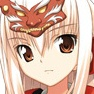

In [8]:
view_rand_img()

In [9]:
# There are some invalid images...
display_image('/content/AnimeGANs/cropped/44478_2013.jpg')

In [10]:
for img_name in os.listdir('/content/AnimeGANs/cropped/'):
  img_path = f'/content/AnimeGANs/cropped/{img_name}'
  try:
    _ = PIL.Image.open(img_path)
  except PIL.UnidentifiedImageError:
    print(f'{img_path} is an invalid image')
    os.remove(img_path)

/content/AnimeGANs/cropped/5964_2003.jpg is an invalid image
/content/AnimeGANs/cropped/32445_2011.jpg is an invalid image
/content/AnimeGANs/cropped/35751_2011.jpg is an invalid image
/content/AnimeGANs/cropped/26648_2009.jpg is an invalid image
/content/AnimeGANs/cropped/10877_2005.jpg is an invalid image
/content/AnimeGANs/cropped/46998_2014.jpg is an invalid image
/content/AnimeGANs/cropped/23057_2008.jpg is an invalid image
/content/AnimeGANs/cropped/4118_2002.jpg is an invalid image
/content/AnimeGANs/cropped/32898_2011.jpg is an invalid image
/content/AnimeGANs/cropped/28321_2010.jpg is an invalid image
/content/AnimeGANs/cropped/6188_2003.jpg is an invalid image
/content/AnimeGANs/cropped/58070_2017.jpg is an invalid image
/content/AnimeGANs/cropped/54885_2016.jpg is an invalid image
/content/AnimeGANs/cropped/25213_2009.jpg is an invalid image
/content/AnimeGANs/cropped/54405_2016.jpg is an invalid image
/content/AnimeGANs/cropped/8331_2004.jpg is an invalid image
/content/Ani

Create DataLoaders

In [36]:
ROOT_IMAGE_DIR = '/content/'
IMAGE_SIZE = 64
BATCH_SIZE = 128
LATENT_SIZE = 100
NUM_CHANNELS = 3
STATS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder(ROOT_IMAGE_DIR, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(*STATS)]))

In [13]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=3)

In [14]:
def show_batch(dl):
  images, _ = next(iter(dl))
  plt.figure(figsize=(8,8))
  plt.axis("off")
  # permuting because matplotlib needs (x,y, num channels) while tensor is (num channels, x, y)
  plt.imshow(make_grid(images.detach()[0:64],padding=2,normalize=True,).permute(1,2,0));

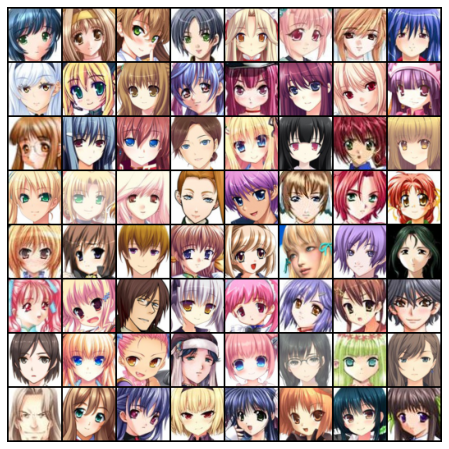

In [15]:
show_batch(train_dl)

In [16]:
device = get_default_device()
device

device(type='cpu')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

In [18]:
images,labels = next(iter(train_dl))
images.shape, labels.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

Confirm shapes with Discriminator and Generator

In [19]:
# Discriminator classifies if an image is real or not
  # input is a batch of images
  # output is a batch of results
discriminator = Discriminator(num_features = 64)
discriminator = to_device(discriminator, device)
images,labels = next(iter(train_dl))

print(f'INPUT: ',images.shape)
out = discriminator(images)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 3, 64, 64])
OUTPUT:  torch.Size([128, 1])


In [20]:
# Generator takes a vector of noise and creates images
  # input is batch of noise/random 
  # output is a batch of images

latent_vector_len = 100
generator = Generator(latent_vector_len = latent_vector_len,num_features = 64)
generator = to_device(generator, device)
noise = torch.randn(BATCH_SIZE, latent_vector_len, 1, 1, device=device)
print(f'INPUT: ',noise.shape)
out = generator(noise)
print('OUTPUT: ',out.shape)

INPUT:  torch.Size([128, 100, 1, 1])
OUTPUT:  torch.Size([128, 3, 64, 64])


Training Loop

In [21]:
'''
pseudo code of training loop:

for epoch in epochs:
  for batch in train dataloader:
    
    # Train Discriminator
    - forward pass of {real} images to Discriminator
    - calculate loss + backwards pass

    - create batch of fake images from Generator
    - forward pass of images to Discriminator
    - calculate loss + backwards pass

    - add both gradients from both losses  + update Discriminator weights

    # Train Generator
    - foward pass of latent vector to create fake images
    - forward pass of fake images to Discriminator
    - calculate loss (how well the discrimator classifies the images are fake)
    - backwards pass + update weights
'''

'\npseudo code of training loop:\n\nfor epoch in epochs:\n  for batch in train dataloader:\n    \n    # Train Discriminator\n    - forward pass of {real} images to Discriminator\n    - calculate loss + backwards pass\n\n    - create batch of fake images from Generator\n    - forward pass of images to Discriminator\n    - calculate loss + backwards pass\n\n    - add both gradients from both losses  + update Discriminator weights\n\n    # Train Generator\n    - foward pass of latent vector to create fake images\n    - forward pass of fake images to Discriminator\n    - calculate loss (how well the discrimator classifies the images are fake)\n    - backwards pass + update weights\n'

In [48]:
# TODO: discriminator, model, and device should be params?
def train_discriminator(images):

  # pass through real images
  predictions_real = discriminator(images)
  labels = torch.ones(BATCH_SIZE,1,device=device)
  loss_real = F.binary_cross_entropy(predictions_real, labels)

  # create fake images from the generator
  noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
  fake_images = generator(noise)
  
  # pass through fake images
  predictions_fake = discriminator(fake_images)
  labels = torch.zeros(BATCH_SIZE,1,device=device)
  loss_fake = F.binary_cross_entropy(predictions_fake, labels)

  # backwards pass and update discriminator weights
    # total_loss = loss_fake + loss_real
    # total_loss.backward() should be the same thing (?)
  loss_fake.backward()
  loss_real.backward()
  total_loss = loss_fake + loss_real
  
  optimizerD.step()

  # return total loss, 'score' of real predictions, and 'score' of fake predictions
  return total_loss.item(), torch.mean(predictions_real).mean(), torch.mean(predictions_fake).mean()

In [49]:
images, _ = next(iter(train_dl))

optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
train_discriminator(images)

(0.010356456972658634,
 tensor(0.9909, grad_fn=<MeanBackward0>),
 tensor(4.4594e-05, grad_fn=<MeanBackward0>))

In [23]:
def train_generator():
  pass